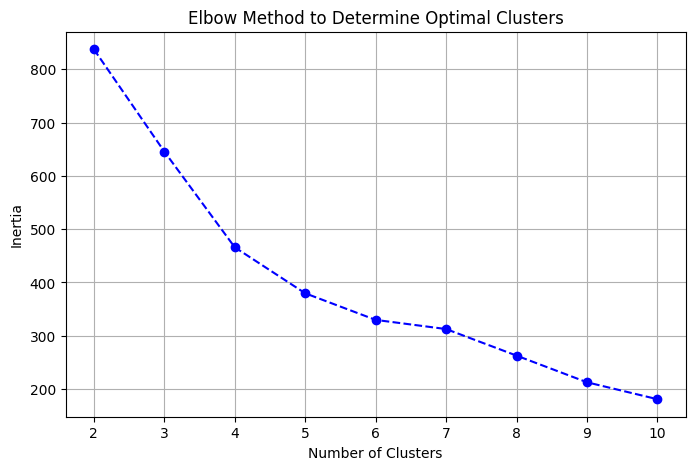

### Clustering Metrics ###
Number of Clusters: 4
Davies-Bouldin Index: 0.9881
Silhouette Score: 0.3964
Calinski-Harabasz Index: 101.5672


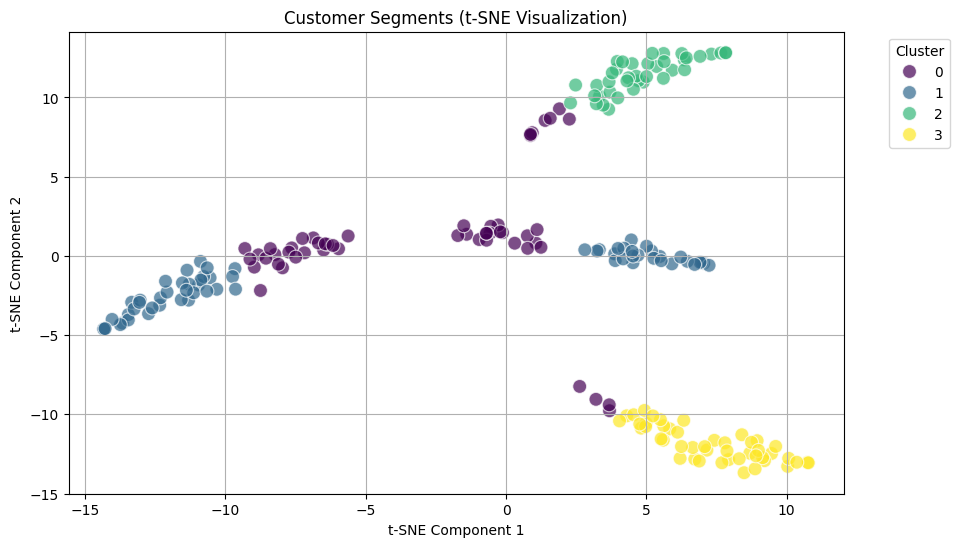

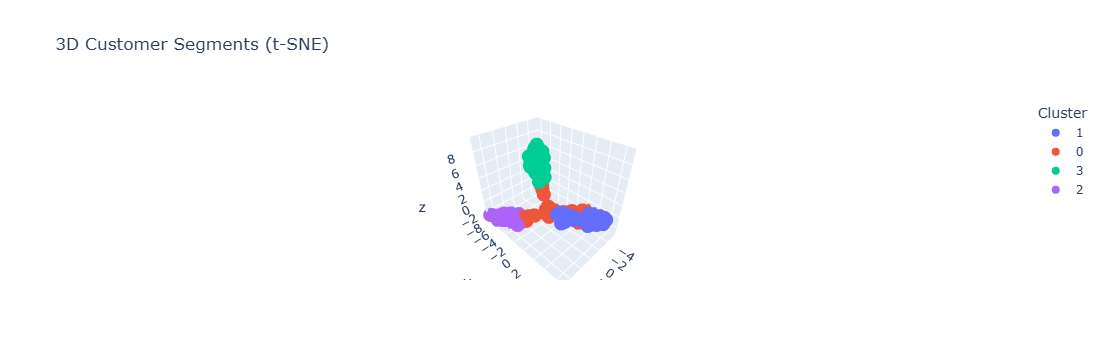

<Figure size 1000x600 with 0 Axes>

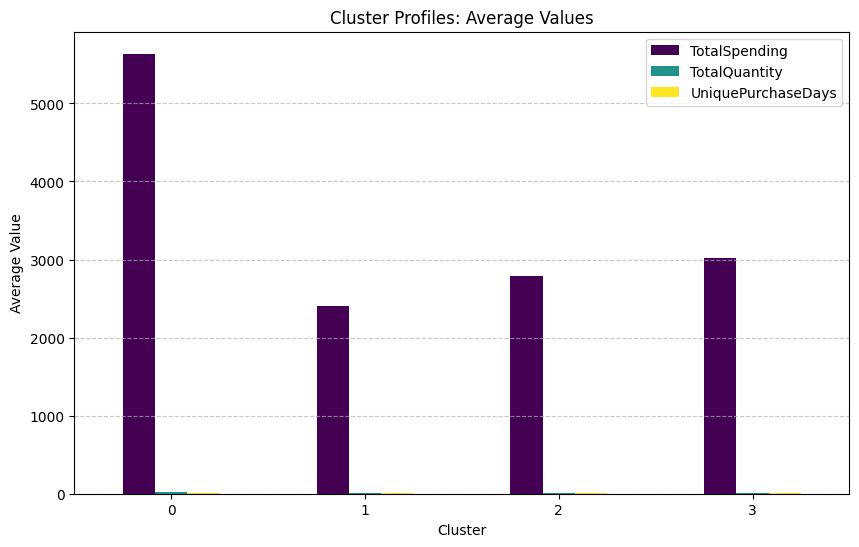

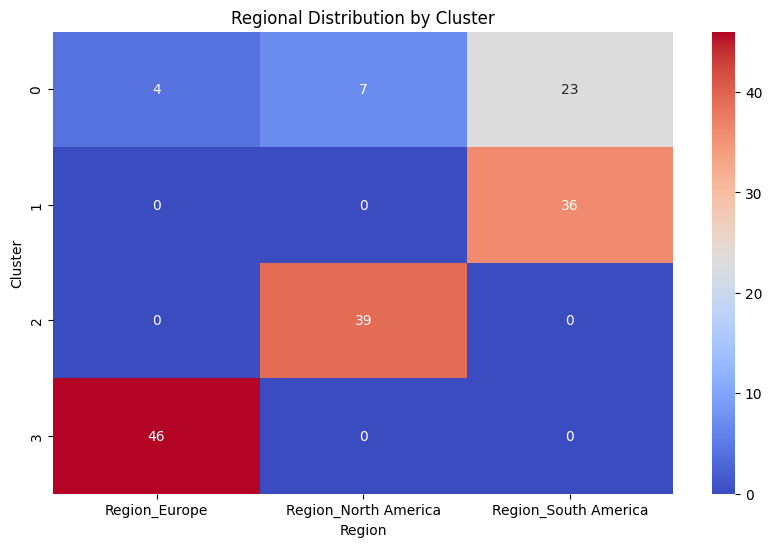

In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Feature engineering
data['TotalSpending'] = data['Quantity'] * data['Price']
aggregated_data = data.groupby('CustomerID').agg(
    TotalSpending=('TotalSpending', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    UniquePurchaseDays=('TransactionDate', 'nunique')
).reset_index()

# Merge with customer data
customer_data = pd.merge(aggregated_data, customers, on='CustomerID', how='inner')

# Encode categorical variables
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalize numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])
)

# Determine optimal number of clusters using Elbow Method
inertia = []
for k in range(2, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(scaled_features)
    inertia.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Apply K-Means clustering
optimal_clusters = 4  # Update based on Elbow Method result
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])
calinski_harabasz = calinski_harabasz_score(scaled_features, customer_data['Cluster'])

print("### Clustering Metrics ###")
print(f"Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")

# Visualization
# 1. t-SNE for 2D Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_2d = tsne.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=tsne_2d[:, 0], y=tsne_2d[:, 1], 
    hue=customer_data['Cluster'], 
    palette='viridis', s=100, alpha=0.7
)
plt.title('Customer Segments (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# 2. 3D Visualization with Plotly
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_3d_data = tsne_3d.fit_transform(scaled_features)

fig = px.scatter_3d(
    x=tsne_3d_data[:, 0], 
    y=tsne_3d_data[:, 1], 
    z=tsne_3d_data[:, 2], 
    color=customer_data['Cluster'].astype(str),
    title='3D Customer Segments (t-SNE)',
    labels={'color': 'Cluster'}
)
fig.show()

# 3. Cluster Profile Bar Chart
numeric_columns = customer_data.select_dtypes(include=[np.number]).columns
cluster_means = customer_data.groupby('Cluster')[numeric_columns].mean()

# Keep relevant features for the bar plot
cluster_means = cluster_means[['TotalSpending', 'TotalQuantity', 'UniquePurchaseDays']]

plt.figure(figsize=(10, 6))
cluster_means.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Cluster Profiles: Average Values')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Heatmap of Regional Distribution
region_columns = [col for col in customer_data.columns if col.startswith('Region_')]
region_distribution = customer_data.groupby('Cluster')[region_columns].sum()

plt.figure(figsize=(10, 6))
sns.heatmap(region_distribution, annot=True, fmt='d', cmap='coolwarm')
plt.title('Regional Distribution by Cluster')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.show()

# Export clustered data for further analysis
customer_data.to_csv('Customer_Clusters_Final.csv', index=False)
